# Setup

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
%run ../Style_sheet.ipynb
%matplotlib inline

In [3]:
def preview(dataframe, head=5):
    display(dataframe.head(head))
    print("This dataframe has " + str(len(dataframe)) + " rows.")

## Aircraft Types

In [4]:
# Import the aircraft type lookup table
ac_lookup = pd.read_csv('data_inputs/aircraft_type_designators.csv',index_col=0)

## Import correction data

In [5]:
jan2019 = pd.read_csv('../results/correction_data/jan2019.csv',index_col=0)
jan2019["ds"] = 'j19'
jan2018 = pd.read_csv('../results/correction_data/jan2018.csv',index_col=0)
jan2018["ds"] = 'j18'
aug2018 = pd.read_csv('../results/correction_data/aug2018.csv',index_col=0)
aug2018["ds"] = 'a18'
summary = pd.concat([jan2019,jan2018,aug2018])
preview(summary)

,flight_id,callsign,aircraft_type,departure,arrival,distance,gc_distance,max_alt,ds
0,1,EWG5B,A319,LOWW,LEBL,1402.588790,1366.368528,35050.0,j19
1,2,SCW20M,RJ1H,ESSB,ESMS,513.593468,499.471877,30025.0,j19
2,4,AEA1039,B738,LEMG,LFPG,1595.619497,1485.213949,36025.0,j19
3,5,TGZ930,B737,UGTB,UUWW,1695.302254,1643.360216,38025.0,j19
4,6,EZY5741,A320,EDDT,EPWA,574.713620,525.950923,35025.0,j19


This dataframe has 223768 rows.


The above data was created from Airnav Systems flight track data. The "distance" column represents the flight path distance and was calculated by taking the sum of the great circle distance between all consecutive position coordinates. The "gc_distance" column is the great circle distance between the first and last record position coordinates.

# Data Cleaning

## Aircraft Filter

Filter aircraft types that are not present in the OAG data set

In [6]:
dist_df = summary.loc[summary.aircraft_type.isin(ac_lookup.ac_code_icao)].copy()
len(dist_df)

218930

## Great Circle Distance > 100km

Flights less than 100 km are often erroneous

In [7]:
dist_df = dist_df.loc[dist_df.gc_distance > 100]
len(dist_df.sort_values('gc_distance',ascending=False))

212452

## Great Circle Distance < 13000 km

There are a few flights with distances very large. These are outliers and should be removed

In [8]:
dist_df = dist_df.loc[dist_df.gc_distance<13000].copy()
len(dist_df)

212428

## GC_distance < Distance

It is impossible for the great circle distance to be greater than than a flight path distance and these apparently erroneous instances are removed.

In [9]:
dist_df = dist_df.loc[dist_df.gc_distance<dist_df.distance].copy()
len(dist_df)

212423

## Distance Ratio < 2

Flights for which the distance ratio is greater than 2 are often found to be erroneous

In [10]:
dist_df['dist_ratio'] = dist_df.distance / dist_df.gc_distance

In [11]:
dist_df = dist_df.loc[dist_df.dist_ratio < 2].copy()
len(dist_df.sort_values(by='dist_ratio',ascending=False))

211874

In [12]:
print('{:,.0f} out of {:,.0f} flights remain for analysis ({:,.1f}%)'.format(len(dist_df),len(summary),len(dist_df)/len(summary)*100))

211,874 out of 223,768 flights remain for analysis (94.7%)


# Parameters by aircraft

For aircraft that have a large number of flights available in the flight track dataset (>500 flights), a flight distance correction equation is calculated for each.

## Analysis

In [13]:
aircraft_fits_dict = {'ac_code_icao':[],'a':[],'b':[],'a_ci_low':[],'a_ci_high':[],'b_ci_low':[],'b_ci_high':[],
                      'r_squared':[],'sample_size':[]}
for aircraft in dist_df.aircraft_type.unique():
    df_slice = dist_df[dist_df.aircraft_type==aircraft].copy()
    if len(df_slice) >= 500:
        # OLS Linear Regression
        x = df_slice.gc_distance
        y = df_slice.distance
        X = sm.add_constant(x)
        model = sm.OLS(y,X)
        results = model.fit()
        aircraft_fits_dict['ac_code_icao'].append(aircraft)
        aircraft_fits_dict['a'].append(results.params[1])
        aircraft_fits_dict['b'].append(results.params[0])
        aircraft_fits_dict['a_ci_low'].append(results.conf_int().loc['gc_distance',0])
        aircraft_fits_dict['a_ci_high'].append(results.conf_int().loc['gc_distance',1])
        aircraft_fits_dict['b_ci_low'].append(results.conf_int().loc['const',0])
        aircraft_fits_dict['b_ci_high'].append(results.conf_int().loc['const',1])
        aircraft_fits_dict['r_squared'].append(results.rsquared)
        aircraft_fits_dict['sample_size'].append(len(df_slice))
aircraft_fits = pd.DataFrame(aircraft_fits_dict)
preview(aircraft_fits.sort_values('sample_size',ascending=False),5)

,ac_code_icao,a,b,a_ci_low,a_ci_high,b_ci_low,b_ci_high,r_squared,sample_size
3,A320,1.031552,51.557211,1.030735,1.032369,50.377724,52.736698,0.991569,52082
1,B738,1.028760,49.229441,1.027942,1.029578,47.753489,50.705392,0.992933,43277
0,A319,1.030261,50.537725,1.029041,1.031480,49.192046,51.883404,0.990254,26984
14,A321,1.028720,53.324978,1.027491,1.029950,51.164031,55.485925,0.992907,19211
34,B77W,1.039388,75.325155,1.036320,1.042457,51.976499,98.673811,0.987818,5440


This dataframe has 40 rows.


## Correlation Identifier

### Range

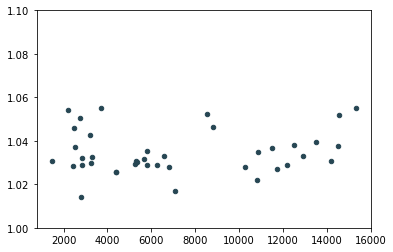

In [14]:
aircraft_ranges = pd.read_csv('data_inputs/aircraft_ranges.csv',index_col=0)
range_corr = aircraft_fits.merge(aircraft_ranges,how='left',left_on='ac_code_icao',right_index=True)
plt.scatter(range_corr.max_range,range_corr.a,s=20)
plt.ylim(1,1.1);

There doesn't appear to be any correlation between an aircraft's range and the great circle coefficient ('a')

### Seat Capacity

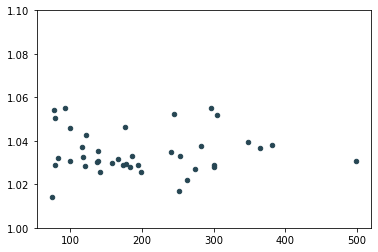

In [15]:
aircraft_seats = pd.read_csv('data_inputs/aircraft_seats.csv',index_col=0)
seat_corr = aircraft_fits.merge(aircraft_seats[['ac_code_icao','seats']],how='left',on='ac_code_icao')
plt.scatter(seat_corr.seats,seat_corr.a,s=20)
plt.ylim(1,1.1);

There doesn't appear to be any correlation between an aircraft's seat capacity and the great circle coefficient ('a')

Due to the lack of correlation to key aircraft characteristics, and the absence of sufficient flight data for each aircraft that is modeled, the approach of calculating a correction factor for each aircraft type is abandoned for the following aggregated method

# Completely Aggregated

In [16]:
preview(dist_df)

,flight_id,callsign,aircraft_type,departure,arrival,distance,gc_distance,max_alt,ds,dist_ratio
0,1,EWG5B,A319,LOWW,LEBL,1402.588790,1366.368528,35050.0,j19,1.026508
1,2,SCW20M,RJ1H,ESSB,ESMS,513.593468,499.471877,30025.0,j19,1.028273
2,4,AEA1039,B738,LEMG,LFPG,1595.619497,1485.213949,36025.0,j19,1.074336
3,5,TGZ930,B737,UGTB,UUWW,1695.302254,1643.360216,38025.0,j19,1.031607
4,6,EZY5741,A320,EDDT,EPWA,574.713620,525.950923,35025.0,j19,1.092713


This dataframe has 211874 rows.


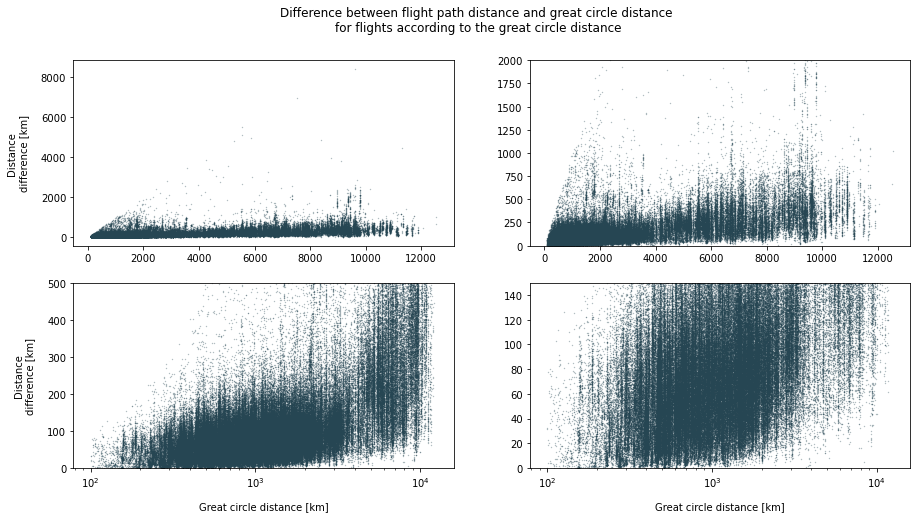

In [17]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,7.5))
dist_df['dist_diff'] = dist_df.distance - dist_df.gc_distance
ax = ax.reshape((1,4))[0]
for axis in ax:
    axis.scatter(dist_df.gc_distance,dist_df.dist_diff,s=.1,alpha=.5)
ax[0].set_ylabel('Distance\ndifference [km]')
ax[2].set_ylabel('Distance\ndifference [km]')
ax[1].set_ylim(0,2000)
ax[2].set_ylim(0,500)
ax[2].set_xscale('log')
ax[3].set_ylim(0,150)
ax[3].set_xscale('log')
ax[2].set_xlabel('Great circle distance [km]')
ax[3].set_xlabel('Great circle distance [km]')
fig.suptitle('Difference between flight path distance and great circle distance \nfor flights according to the great circle distance');

The plots above suggest that there is a correlation between the great circle distance between the start and end point of a flight path and the length of the path itself. We therefore employ a regression model to approximately capture the behavior.

## Analysis

In [18]:
# OLS Linear Regression
x = dist_df.gc_distance
y = dist_df.distance
X = sm.add_constant(x)
model = sm.OLS(y,X)
results = model.fit()
a = results.params[1]
b = results.params[0]
a_ci_low = results.conf_int().loc['gc_distance',0]
a_ci_high = results.conf_int().loc['gc_distance',1]
b_ci_low = results.conf_int().loc['const',0]
b_ci_high = results.conf_int().loc['const',1]
r_squared = results.rsquared
print(results.summary())
print('\nGreat circle cofficient: {:.4f} \n\
--- 95% CI: ({:.4f},{:.4f})\n\
Constant: {:.3f} \n\
--- 95% CI: ({:.4f},{:.4f})\n\
R-squared: {:.4f}'.format(a,a_ci_low,a_ci_high,b,b_ci_low,b_ci_high,r_squared))

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 8.908e+07
Date:                Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                        15:03:20   Log-Likelihood:            -1.3091e+06
No. Observations:              211874   AIC:                         2.618e+06
Df Residuals:                  211872   BIC:                         2.618e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          40.5491      0.344    117.786      

## Plots

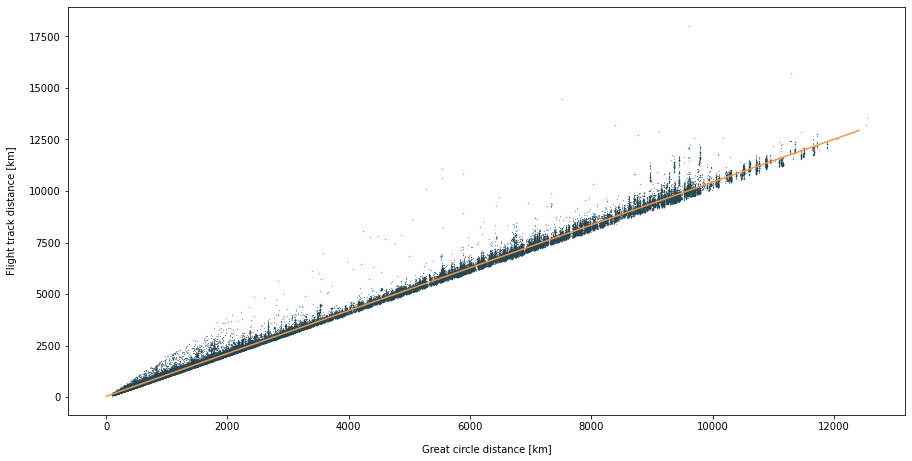

In [19]:
plt.figure(figsize=(15,7.5))
# Scatter
plt.scatter(dist_df.gc_distance, dist_df.distance,s=0.05, label='AirNav Systems Flight')
# Regression
x_plot = np.arange(0,dist_df.gc_distance.max(),dist_df.gc_distance.max()/100)
y_est_plot = a*x_plot+b
plt.plot(x_plot,y_est_plot,linewidth=1.5,label='y = {:.3f}*x+{:.3f}'.format(a,b),color='C1')
# plt.axis((0,12000,1,1.55));
plt.xlabel('Great circle distance [km]')
plt.ylabel('Flight track distance [km]');

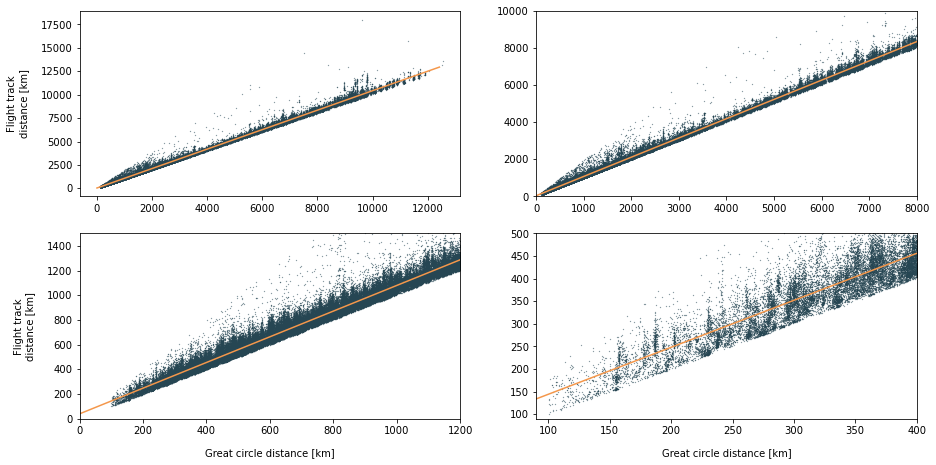

In [20]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,7.5))
dist_df['dist_diff'] = dist_df.distance - dist_df.gc_distance
ax = ax.reshape((1,4))[0]
# Regression
x_plot = np.arange(0,dist_df.gc_distance.max(),dist_df.gc_distance.max()/100)
y_est_plot = a*x_plot+b
for axis in ax:
    # Scatter
    axis.scatter(dist_df.gc_distance, dist_df.distance,s=0.05, label='AirNav Systems Flight')
    axis.plot(x_plot,y_est_plot,linewidth=1.5,label='y = {:.3f}*x+{:.3f}'.format(a,b),color='C1')
ax[0].set_ylabel('Flight track\ndistance [km]')
ax[2].set_ylabel('Flight track\ndistance [km]')
ax[1].set_ylim(0,10000)
ax[1].set_xlim(0,8000)
ax[2].set_ylim(0,1500)
ax[2].set_xlim(0,1200)
ax[3].set_ylim(90,500)
ax[3].set_xlim(90,400)
ax[2].set_xlabel('Great circle distance [km]')
ax[3].set_xlabel('Great circle distance [km]');

# Data set filter sensitivities

We investigate the sensitivities of the regression coefficients to the filtering criteria chosen for the data set.

## Lower great circle distance limit sensitivity

In [21]:
# Filter the data set as before, but without the first criteria (great circle distance > 100 km)
lower_lim = summary.loc[summary.aircraft_type.isin(ac_lookup.ac_code_icao)].copy()
lower_lim = lower_lim.loc[lower_lim.gc_distance<13000]
lower_lim = lower_lim.loc[lower_lim.gc_distance<lower_lim.distance]
lower_lim['dist_ratio'] = lower_lim.distance / lower_lim.gc_distance
lower_lim = lower_lim.loc[lower_lim.dist_ratio < 2]

In [22]:
llims = np.arange(50,250,2)
llim_params = {'a':[],'b':[]}
for limit in llims:
    # OLS Linear Regression
    temp = lower_lim[lower_lim.gc_distance>limit].copy()
    x = temp.gc_distance
    y = temp.distance
    X = sm.add_constant(x)
    model = sm.OLS(y,X)
    results = model.fit()
    a = results.params[1]
    b = results.params[0]
    llim_params['a'].append(a)
    llim_params['b'].append(b)

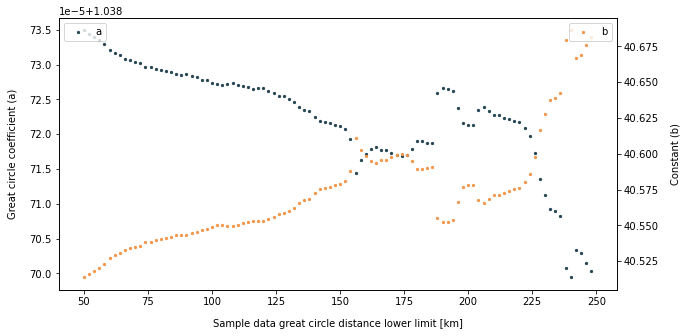

In [23]:
fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(llims,llim_params['a'],s=5,label='a')
ax2 = ax.twinx()
ax2.scatter(llims,llim_params['b'],s=5,color='C1',label='b')
ax.set_ylabel('Great circle coefficient (a)')
ax2.set_ylabel('Constant (b)')
ax.set_xlabel('Sample data great circle distance lower limit [km]')
ax.legend(loc='upper left')
ax2.legend(loc='upper right');

The above scatter plot shows the regression parameters, a and b, for a range of distances by which the sample data set was filtered. For example, the points at 150 km show the regression coefficients calculated from the data set that was created by filtering out all flights below 150 km. The variation in both parameters is sufficiently small for all tested lower limits to suggest the selection of the 100 km limit does not introduce any significant bias in the regression analysis.

In [24]:
print("If the lower limit were 50 km, a 13,000 km distance would be corrected to {:,.1f} km.".format(13000*llim_params['a'][0]+llim_params['b'][0]))
print("If the lower limit were 250 km, a 13,000 km distance would be corrected to {:,.1f} km.".format(13000*llim_params['a'][-1]+llim_params['b'][-1]))
print('Thus, the difference in parameters is negligible')

If the lower limit were 50 km, a 13,000 km distance would be corrected to 13,544.1 km.
If the lower limit were 250 km, a 13,000 km distance would be corrected to 13,543.8 km.
Thus, the difference in parameters is negligible


## Upper great circle distance limit sensitivity

In [25]:
# Filter the data set as before, but without the first criteria (great circle distance > 100 km)
upper_lim = summary.loc[summary.aircraft_type.isin(ac_lookup.ac_code_icao)].copy()
dist_df = dist_df.loc[dist_df.gc_distance > 100]
upper_lim = upper_lim.loc[upper_lim.gc_distance<upper_lim.distance]
upper_lim['dist_ratio'] = upper_lim.distance / upper_lim.gc_distance
upper_lim = upper_lim.loc[upper_lim.dist_ratio < 2]

In [26]:
ulims = np.arange(11000,15000,50)
ulim_params = {'a':[],'b':[]}
for limit in ulims:
    # OLS Linear Regression
    temp = upper_lim[upper_lim.gc_distance<limit].copy()
    x = temp.gc_distance
    y = temp.distance
    X = sm.add_constant(x)
    model = sm.OLS(y,X)
    results = model.fit()
    a = results.params[1]
    b = results.params[0]
    ulim_params['a'].append(a)
    ulim_params['b'].append(b)

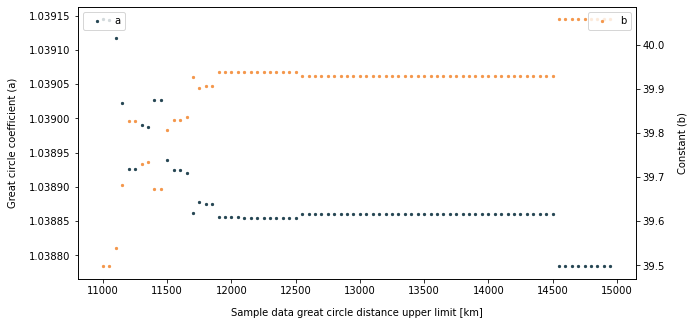

In [27]:
fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(ulims,ulim_params['a'],s=5,label='a')
ax2 = ax.twinx()
ax2.scatter(ulims,ulim_params['b'],s=5,color='C1',label='b')
ax.set_ylabel('Great circle coefficient (a)')
ax2.set_ylabel('Constant (b)')
ax.set_xlabel('Sample data great circle distance upper limit [km]')
ax.legend(loc='upper left')
ax2.legend(loc='upper right');

The above scatter plot shows the regression parameters, a and b, for a range of distances by which the sample data set was filtered. For example, the points at 14,000 km show the regression coefficients calculated from the data set that was created by filtering out all flights above 14,000 km. The points at 12,000 km show the regression coefficients calculated from the data set that was created by filtering out all flights above 12,000 km. It is clear that the parameters are not sensitive the upper great circle filter limit until it is reduced below 12,000 km at which point we start to filter a significant number of flights. Thus, we conclude 13,000 km is a suitable upper great circle distance limit for filtering.

## Upper great circle distance limit sensitivity

In [28]:
# Filter the data set as before, but without the first criteria (great circle distance > 100 km)
distance_ratio_cutoff = summary.loc[summary.aircraft_type.isin(ac_lookup.ac_code_icao)].copy()
dist_df = dist_df.loc[dist_df.gc_distance > 100]
dist_df = dist_df.loc[dist_df.gc_distance < 13000]
distance_ratio_cutoff = distance_ratio_cutoff.loc[distance_ratio_cutoff.gc_distance<distance_ratio_cutoff.distance]
distance_ratio_cutoff['dist_ratio'] = distance_ratio_cutoff.distance / distance_ratio_cutoff.gc_distance

In [29]:
drs = np.arange(1.8,2.2,.01)
dr_params = {'a':[],'b':[]}
for dr_cutoff in drs:
    # OLS Linear Regression
    temp = distance_ratio_cutoff.loc[distance_ratio_cutoff.dist_ratio < dr_cutoff].copy()
    x = temp.gc_distance
    y = temp.distance
    X = sm.add_constant(x)
    model = sm.OLS(y,X)
    results = model.fit()
    a = results.params[1]
    b = results.params[0]
    dr_params['a'].append(a)
    dr_params['b'].append(b)

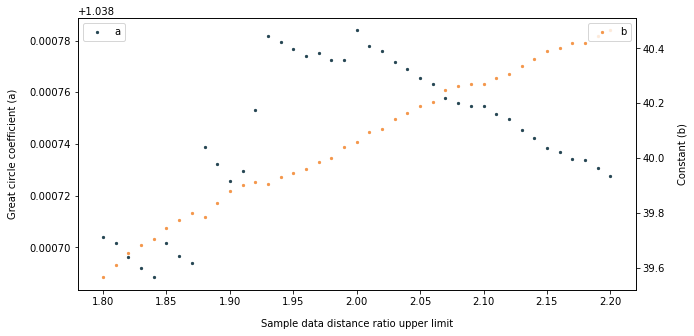

In [30]:
fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(drs,dr_params['a'],s=5,label='a')
ax2 = ax.twinx()
ax2.scatter(drs,dr_params['b'],s=5,color='C1',label='b')
ax.set_ylabel('Great circle coefficient (a)')
ax2.set_ylabel('Constant (b)')
ax.set_xlabel('Sample data distance ratio upper limit')
ax.legend(loc='upper left')
ax2.legend(loc='upper right');

The above scatter plot shows the regression parameters, a and b, for a range of distance ratios by which the sample data set was filtered. For example, the points at 1.90 show the regression coefficients calculated from the data set that was created by filtering out all flights for which the ratio of the flight path distance to the great circle distance was greater than 1.9. The variation in both parameters is sufficiently small for all tested distance ratio limits to suggest the selection of the limit (ratio=2) does not introduce any significant bias in the regression analysis.

In [31]:
print("If the distance ratio upper limit were 1.8 km, a 13,000 km distance would be corrected to {:,.1f} km.".format(13000*dr_params['a'][0]+dr_params['b'][0]))
print("If the distance ratio upper limit were 2.2 km, a 13,000 km distance would be corrected to {:,.1f} km.".format(13000*dr_params['a'][-1]+dr_params['b'][-1]))
print('Thus, the difference in parameters is negligible')

If the distance ratio upper limit were 1.8 km, a 13,000 km distance would be corrected to 13,542.7 km.
If the distance ratio upper limit were 2.2 km, a 13,000 km distance would be corrected to 13,543.9 km.
Thus, the difference in parameters is negligible
